In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install monai
!pip install torchmetrics==0.7.2
!pip install transformers
!pip install einops
!pip install timm==0.4.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.2/397.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 5.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import py
from sklearn.metrics import classification_report
from monai.data import decollate_batch, DataLoader, CacheDataset, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    EnsureTyped,
    Resized,
    CropForegroundd,
    SpatialPadd,
    CastToTyped,
)
from monai.utils import set_determinism


In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.4.12
    Uninstalling timm-0.4.12:
      Successfully uninstalled timm-0.4.12
Cloning into 'mae'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Receiving objects: 100% (39/39), 829.54 KiB | 18.03 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [ ]:
def set_seed(no):
    torch.manual_seed(no)
    random.seed(no)
    np.random.seed(no)
    os.environ['PYTHONHASHSEED'] = str()
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(100)

In [9]:
import pandas as pd
import os
from enum import Enum
from monai.transforms import Transform

class Modality(Enum):
    MR_T1 = 1
    MR_T2 = 2
    MR_T2_STAR = 3
    MR_FLAIR = 4
    MR_TOF_MRA = 5

def create_oasis_3_unimodal_dataset(csv_path: str, dataset_root: str, modality: Modality, transform: Transform, cache_rate: float):
    train_df = pd.read_csv(csv_path, sep=";")
    train_df.fillna('', inplace=True)

    column_name = ""
    if modality == Modality.MR_T1:
        column_name = "MR T1w"
    elif modality == Modality.MR_T2:
        column_name = "MR T2w"
    elif modality == Modality.MR_T2_STAR:
        column_name = "MR T2*"
    elif modality == Modality.MR_FLAIR:
        column_name = "MR FLAIR"
    elif modality == Modality.MR_TOF_MRA:
        column_name = "MR TOF-MRA"
    else:
        assert(False)

    train_data = []
    for index, row in train_df.iterrows():
        rel_path = row[column_name]
        if not rel_path:
            continue
        image_path = os.path.join(dataset_root, rel_path)
        train_data.append({"image": image_path, "label" : row["label"]})
        print(train_data)

    return CacheDataset(data=train_data, transform=transform, cache_rate=cache_rate, num_workers=5, copy_cache=False)

In [6]:
dataset_root = r"/content/drive/MyDrive/OASIS-3-MR-Sessions-2D"

In [10]:
resolution = 224
cache_rate = 0.1 # might need to change this based on the amount of memory available
batch_size = 16
modality = Modality.MR_TOF_MRA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
foreground_crop_threshold = 0.1
# train_table_path = "csv/oasis/oasis_3_multimodal_train.csv"
train_table_path = r"/content/drive/MyDrive/MLMI/oasis_3_multimodal_train.csv"
transform = Compose([
    LoadImaged("image", image_only=True),
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    CastToTyped("label", dtype=np.float64),
    ScaleIntensityd("image"),
    CropForegroundd("image", source_key="image", select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    Resized(keys=["image"], spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=["image"], spatial_size=(resolution, resolution)),
    EnsureTyped("image", device=device),
    ]
)

# TODO: fix the following files
# TODO: skip them in the dataset
'''
torch.Size([96, 96, 26])
Error transforming file: /mnt/f/OASIS-3-MR-Sessions-2D/OAS30033_MR_d0133/anat5/NIFTI/sub-OAS30033_ses-d0133_run-02_T2w.nii.gz

torch.Size([64, 64, 105])
Error transforming file: /mnt/f/OASIS-3-MR-Sessions-2D/OAS31065_MR_d0044/anat7/NIFTI/sub-OAS31065_ses-d0044_echo-1_run-02_FLAIR.nii.gz
'''

train_ds = create_oasis_3_unimodal_dataset(csv_path=train_table_path, dataset_root=dataset_root, modality=modality, transform=transform, cache_rate=cache_rate)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=batch_size, shuffle=True)

# val_table_path = "csv/oasis/oasis_3_multimodal_val.csv"
val_table_path = r"/content/drive/MyDrive/MLMI/oasis_3_multimodal_val.csv"
val_ds = create_oasis_3_unimodal_dataset(csv_path=val_table_path, dataset_root=dataset_root, modality=modality, transform=transform, cache_rate=cache_rate)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=batch_size, shuffle=True)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loading dataset: 100%|██████████| 69/69 [00:14<00:00,  4.65it/s]


[{'image': '/content/drive/MyDrive/OASIS-3-MR-Sessions-2D/OAS31373_MR_d0133/anat1/NIFTI/sub-OAS31373_sess-d0133_acq-TOF_angio.nii.gz', 'label': 0}]
[{'image': '/content/drive/MyDrive/OASIS-3-MR-Sessions-2D/OAS31373_MR_d0133/anat1/NIFTI/sub-OAS31373_sess-d0133_acq-TOF_angio.nii.gz', 'label': 0}, {'image': '/content/drive/MyDrive/OASIS-3-MR-Sessions-2D/OAS30109_MR_d2320/anat5/NIFTI/sub-OAS30109_ses-d2320_acq-TOF_run-01_angio.nii.gz', 'label': 0}]
[{'image': '/content/drive/MyDrive/OASIS-3-MR-Sessions-2D/OAS31373_MR_d0133/anat1/NIFTI/sub-OAS31373_sess-d0133_acq-TOF_angio.nii.gz', 'label': 0}, {'image': '/content/drive/MyDrive/OASIS-3-MR-Sessions-2D/OAS30109_MR_d2320/anat5/NIFTI/sub-OAS30109_ses-d2320_acq-TOF_run-01_angio.nii.gz', 'label': 0}, {'image': '/content/drive/MyDrive/OASIS-3-MR-Sessions-2D/OAS30584_MR_d0096/anat1/NIFTI/sub-OAS30584_ses-d0096_acq-TOF_angio.nii.gz', 'label': 0}]
[{'image': '/content/drive/MyDrive/OASIS-3-MR-Sessions-2D/OAS31373_MR_d0133/anat1/NIFTI/sub-OAS31373_ses

Loading dataset: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


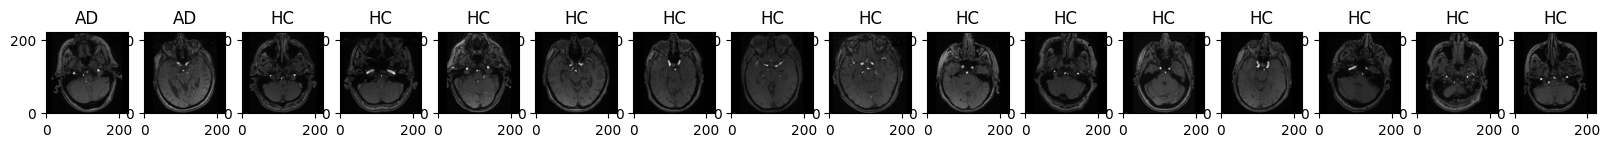

In [ ]:
dataiter = iter(train_loader)
batch_sample = next(dataiter)
images = batch_sample["image"]
labels = batch_sample["label"]

classes = ["HC", "AD"]

plt.figure(figsize=(20, 12))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data.cpu()[0]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
    i += 1
plt.show()

In [ ]:
out_model_dir = r"/content/drive/MyDrive/M3AE_N/pretrained"
model_file_name = f"m3ae_unimodal_oasis_3_{str(modality).split('.')[1]}.pth"

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

--2023-09-17 17:55:43--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.115, 52.222.236.65, 52.222.236.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large.pth’

mae_visualize_vit_l 100%[===================>]   1.23G   214MB/s    in 5.9s    

2023-09-17 17:55:49 (214 MB/s) - ‘mae_visualize_vit_large.pth’ saved [1318315181/1318315181]

<All keys matched successfully>
Model loaded.


In [ ]:
from einops import repeat, rearrange
class ViT_Classifier(torch.nn.Module):
    def __init__(self, mae, num_classes=1) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3)
        )
        self.mae = mae
        self.head = torch.nn.Linear(mae.pos_embed.shape[-1], num_classes)

    def forward(self, img):
        img = self.conv(img)
        features, mask, ids_restore = self.mae.forward_encoder(img, 0)
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits
chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16').cuda()
print('Model loaded.')
model = ViT_Classifier(model_mae).cuda()
# x = torch.ones([2,1,224,224]).cuda()
# print(model(x).shape)

<All keys matched successfully>
Model loaded.


In [ ]:
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
val_interval = 1
auc_metric = ROCAUCMetric()

In [ ]:
from tqdm import tqdm
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

y_pred_trans = Compose([Activations(sigmoid=True)])
max_epochs = 10
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = batch_data["image"].to(device).float(), batch_data["label"].to(device).float()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # print(outputs)
            # print(loss)
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in tqdm(val_loader):
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = torch.cat([i for i in decollate_batch(y, detach=False)], dim=0)
            y_pred_act = torch.cat([y_pred_trans(i) for i in decollate_batch(y_pred)], dim=0)
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(result)
            acc_value = torch.eq((y_pred_act > 0.5).long(), y)
            acc_metric = acc_value.float().mean().item()
            del y_pred_act, y_onehot
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(out_model_dir, model_file_name))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric (AUC): {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/10


100%|██████████| 44/44 [16:32<00:00, 22.56s/it]


epoch 1 average loss: 0.3941


100%|██████████| 6/6 [02:02<00:00, 20.46s/it]


saved new best metric model
current epoch: 1 current AUC: 0.6399 current accuracy: 0.8391 best AUC: 0.6399 at epoch: 1
----------
epoch 2/10


100%|██████████| 44/44 [00:28<00:00,  1.53it/s]


epoch 2 average loss: 0.3443


100%|██████████| 6/6 [00:02<00:00,  2.01it/s]


current epoch: 2 current AUC: 0.6341 current accuracy: 0.8391 best AUC: 0.6399 at epoch: 1
----------
epoch 3/10


100%|██████████| 44/44 [00:27<00:00,  1.59it/s]


epoch 3 average loss: 0.3096


100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


current epoch: 3 current AUC: 0.5910 current accuracy: 0.8391 best AUC: 0.6399 at epoch: 1
----------
epoch 4/10


100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


epoch 4 average loss: 0.2136


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


current epoch: 4 current AUC: 0.5695 current accuracy: 0.8001 best AUC: 0.6399 at epoch: 1
----------
epoch 5/10


100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


epoch 5 average loss: 0.0587


100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


current epoch: 5 current AUC: 0.6380 current accuracy: 0.8079 best AUC: 0.6399 at epoch: 1
----------
epoch 6/10


100%|██████████| 44/44 [00:27<00:00,  1.61it/s]


epoch 6 average loss: 0.0254


100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


current epoch: 6 current AUC: 0.6282 current accuracy: 0.8313 best AUC: 0.6399 at epoch: 1
----------
epoch 7/10


100%|██████████| 44/44 [00:27<00:00,  1.61it/s]


epoch 7 average loss: 0.0063


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


saved new best metric model
current epoch: 7 current AUC: 0.6497 current accuracy: 0.8157 best AUC: 0.6497 at epoch: 7
----------
epoch 8/10


100%|██████████| 44/44 [00:28<00:00,  1.55it/s]


epoch 8 average loss: 0.0034


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


current epoch: 8 current AUC: 0.6282 current accuracy: 0.7923 best AUC: 0.6497 at epoch: 7
----------
epoch 9/10


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


epoch 9 average loss: 0.0023


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


current epoch: 9 current AUC: 0.6262 current accuracy: 0.8001 best AUC: 0.6497 at epoch: 7
----------
epoch 10/10


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


epoch 10 average loss: 0.0018


100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

current epoch: 10 current AUC: 0.6272 current accuracy: 0.8001 best AUC: 0.6497 at epoch: 7
train completed, best_metric (AUC): 0.6497 at epoch: 7
